## タイタニックデータにおける分類精度向上のために分析を実施

In [70]:
import  sys

import seaborn as sns

sys.path.append("../")
from transformer.transformer_csv import TransformerCsv
from utils.load_file import load_data

In [71]:
data = load_data(data_file_name="titanic_training.csv")

### データ説明
* PassengerId – 乗客識別ユニークID
* Survived – 生存フラグ（0=死亡、1=生存）
* Pclass – チケットクラス
* Name – 乗客の名前
* Sex – 性別（male=男性、female＝女性）
* Age – 年齢
* SibSp – タイタニックに同乗している兄弟/配偶者の数
* Parch – タイタニックに同乗している親/子供の数
* Ticket – チケット番号
* Fare – 料金
* Cabin – 客室番号
* Embarked – 出港地（タイタニックへ乗った港）

#### pclass = チケットクラス
* 1 = 上層クラス（お金持ち）
* 2 = 中級クラス（一般階級）
* 3 = 下層クラス（労働階級）

#### Embarked = 各変数の定義は下記の通り
* C = Cherbourg
* Q = Queenstown
* S = Southampton

In [72]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 分類に使わなそうなカラムは削除

In [73]:
data = data.drop(columns="PassengerId")
data = data.drop(columns="Name")
data = data.drop(columns="Ticket")
data = data.drop(columns="Cabin")

### カテゴリカルデータを数値化

In [74]:
transformer = TransformerCsv(data_df=data)

categorical_list = ["Sex", "Embarked"]
transformer.encode_category_to_int(categorical_list=categorical_list)
transformed_data = transformer.plot_data()

In [75]:
transformed_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2
887,1,1,0,19.0,0,0,30.0000,2
888,0,3,0,NaN,1,2,23.4500,2
889,1,1,1,26.0,0,0,30.0000,0


### 数値化後
* Sex : male => 1, female => 0
* Embarked : C => 0, Q => 1, S => 2

In [76]:
transformed_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,1.529742
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.800254
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


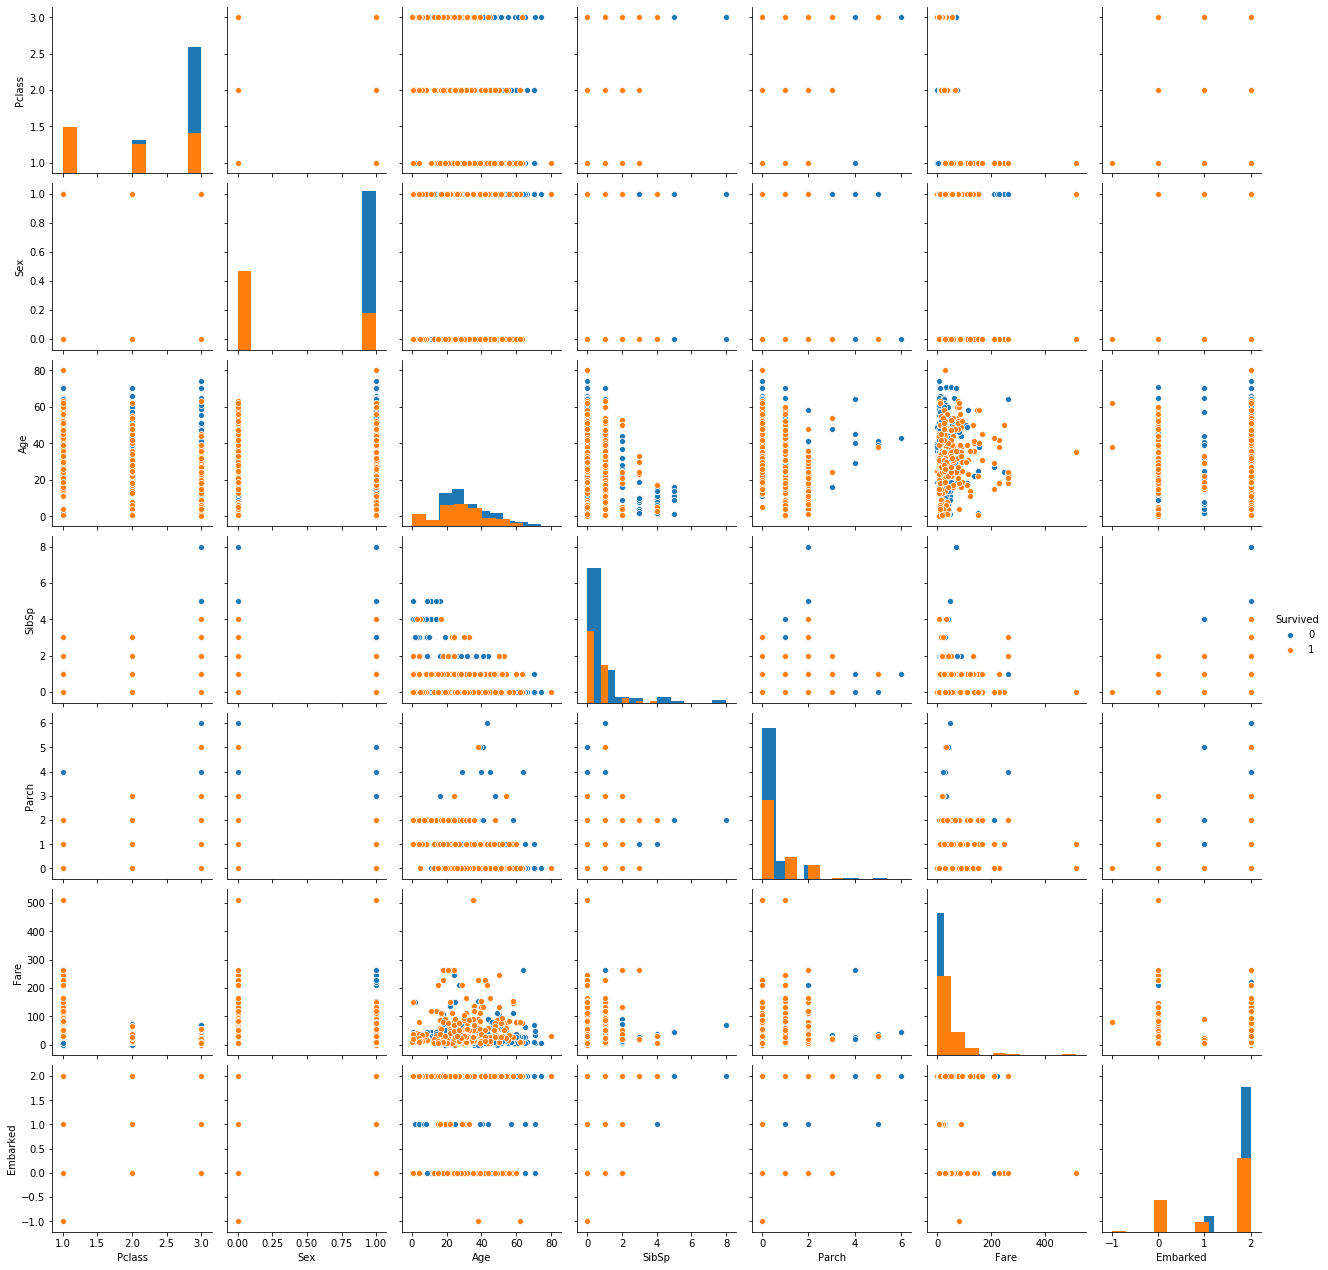

In [77]:
sns.pairplot(transformed_data, hue="Survived", diag_kind="hist")

### 傾向メモ

上記グラフから分析
* Pclassでは生存率に関しては３クラス均等だが、死亡率に関しては「3：下層クラス」が高く、その次に「2：中級クラス」が高い
* Sexでは「1：男性」が死亡率高い
* SIbSp, Parchでは、複数人で搭乗していれば生存率、死亡率は共に約50%。単身で搭乗していた場合、生存率はおおよそ33％、死亡率はおおよそ66%(目測)
* Embarkedでは「2：S = Southampton」で死亡率が高い（そもそもここで搭乗した人数が多いが）

### 以降、生存者、死亡者に分けて分析 

In [78]:
unsurvive_transformed_data = transformed_data.query('Survived == 0')
survive_transformed_data = transformed_data.query('Survived == 1')